In [1]:
import datetime
import pandas as pd

import re
from wordcloud import WordCloud as wc
from konlpy.tag import Okt
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

from collections import Counter

In [2]:
# 한글 폰트 설정 (윈도우 OS)
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/gulim.ttc").get_name()
rc('font', family=font_name)


In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\piai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\piai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\piai\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
webinar_1 = pd.read_excel('../data/webinar_1_v2.xlsx')
webinar_2 = pd.read_excel('../data/webinar_2_v2.xlsx')
webinar_3 = pd.read_excel('../data/webinar_3_v2.xlsx')

In [5]:
webinar_1.columns

Index(['Unnamed: 0', 'CreatedDatetime', 'UserCode', 'Department',
       'UserQuestion', 'Model', 'ResponseTime', '교육일자', '라벨'],
      dtype='object')

In [6]:
webinar_2.columns

Index(['Unnamed: 0', 'CreatedDatetime', 'UserCode', 'Department',
       'UserQuestion', 'Model', 'ResponseTime', '교육일자', 'Unnamed: 8',
       'Unnamed: 9'],
      dtype='object')

In [7]:
webinar_3.columns

Index(['Unnamed: 0', 'CreatedDatetime', 'UserCode', 'Department',
       'UserQuestion', 'Model', 'ResponseTime', '교육일자', '분류'],
      dtype='object')

In [8]:
webinar_2 = webinar_2.rename(columns={'Unnamed: 8': '라벨'}).drop(columns=['Unnamed: 9'])
webinar_3 = webinar_3.rename(columns={'분류': '라벨'})

In [9]:
webinar_1.columns

Index(['Unnamed: 0', 'CreatedDatetime', 'UserCode', 'Department',
       'UserQuestion', 'Model', 'ResponseTime', '교육일자', '라벨'],
      dtype='object')

In [10]:
webinar_2.columns

Index(['Unnamed: 0', 'CreatedDatetime', 'UserCode', 'Department',
       'UserQuestion', 'Model', 'ResponseTime', '교육일자', '라벨'],
      dtype='object')

In [11]:
webinar_3.columns

Index(['Unnamed: 0', 'CreatedDatetime', 'UserCode', 'Department',
       'UserQuestion', 'Model', 'ResponseTime', '교육일자', '라벨'],
      dtype='object')

In [12]:
df_webinar = pd.concat([webinar_1,webinar_2,webinar_3], ignore_index=True)


In [13]:
def ret_yyyymmdd_hhmmss(dt):
    return dt.split(' ')[0]

In [14]:
df_webinar['CreatedDatetime'] = df_webinar['CreatedDatetime'].apply(lambda x: ret_yyyymmdd_hhmmss(x))

In [15]:
df_webinar

,Unnamed: 0,CreatedDatetime,UserCode,Department,UserQuestion,Model,ResponseTime,교육일자,라벨
0,111703,2023-09-07,3636,(광양)인사노무그룹 QSS섹션,대한민국명장선정으로 축하메세지 200자 이내로 작성해줘,gpt-35-turbo-16k,10,2023-09-05,0
1,111708,2023-09-07,3636,(광양)인사노무그룹 QSS섹션,우수숙련기술자 선정으로 축하메세지 200자 이내로 작성해줘,gpt-35-turbo-16k,10,2023-09-05,0
2,111712,2023-09-07,3638,자동차소재연구소 자동차소재표면연구그룹,아래 코딩의 문제를 해결해줘.\n\n코딩\n# calculate 함수에 의한 계산\...,gpt-35-turbo-16k,5,2023-09-05,5
3,111720,2023-09-07,3640,(광양)제강부 제강기술개발섹션,나는 제강전문가야. 아르곤 버블링 시 기포의 크기를 다르게 했을경우 용강 교반능력의...,gpt-35-turbo-16k,15,2023-09-05,2
4,111723,2023-09-07,3642,디지털혁신실 정보보호사무국 보안기획섹션,"내 질문에 하이퍼파라미터 ""beam_width=30"", ""Top_p=0.1"", ""T...",gpt-35-turbo-16k,17,2023-09-05,0
...,...,...,...,...,...,...,...,...,...
7279,146119,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,위 내용을 영어로 번역해주세요,gpt-35-turbo-16k,2,2023-09-20,4
7280,146142,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,"DHL에서는 이 전화번호로 연락시, 수신되지 않는다고 합니다.",gpt-35-turbo-16k,2,2023-09-20,0
7281,146154,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,"긴급히 확인요망""""을 영어로 표현해 주세요",gpt-35-turbo-16k,0,2023-09-20,4
7282,146515,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,The department for deliveries is open 24/7,gpt-35-turbo-16k,1,2023-09-20,0


In [16]:
df_webinar['CreatedDatetime'] = pd.to_datetime(df_webinar['CreatedDatetime'],format='%Y-%m-%d')
df_webinar['교육일자'] = pd.to_datetime(df_webinar['교육일자'],format='%Y-%m-%d')

In [17]:
df_webinar

,Unnamed: 0,CreatedDatetime,UserCode,Department,UserQuestion,Model,ResponseTime,교육일자,라벨
0,111703,2023-09-07,3636,(광양)인사노무그룹 QSS섹션,대한민국명장선정으로 축하메세지 200자 이내로 작성해줘,gpt-35-turbo-16k,10,2023-09-05,0
1,111708,2023-09-07,3636,(광양)인사노무그룹 QSS섹션,우수숙련기술자 선정으로 축하메세지 200자 이내로 작성해줘,gpt-35-turbo-16k,10,2023-09-05,0
2,111712,2023-09-07,3638,자동차소재연구소 자동차소재표면연구그룹,아래 코딩의 문제를 해결해줘.\n\n코딩\n# calculate 함수에 의한 계산\...,gpt-35-turbo-16k,5,2023-09-05,5
3,111720,2023-09-07,3640,(광양)제강부 제강기술개발섹션,나는 제강전문가야. 아르곤 버블링 시 기포의 크기를 다르게 했을경우 용강 교반능력의...,gpt-35-turbo-16k,15,2023-09-05,2
4,111723,2023-09-07,3642,디지털혁신실 정보보호사무국 보안기획섹션,"내 질문에 하이퍼파라미터 ""beam_width=30"", ""Top_p=0.1"", ""T...",gpt-35-turbo-16k,17,2023-09-05,0
...,...,...,...,...,...,...,...,...,...
7279,146119,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,위 내용을 영어로 번역해주세요,gpt-35-turbo-16k,2,2023-09-20,4
7280,146142,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,"DHL에서는 이 전화번호로 연락시, 수신되지 않는다고 합니다.",gpt-35-turbo-16k,2,2023-09-20,0
7281,146154,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,"긴급히 확인요망""""을 영어로 표현해 주세요",gpt-35-turbo-16k,0,2023-09-20,4
7282,146515,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,The department for deliveries is open 24/7,gpt-35-turbo-16k,1,2023-09-20,0


In [18]:
df_webinar['비교 결과'] = df_webinar.apply(lambda row: '이전' if row['CreatedDatetime'] < row['교육일자'] else ('이후' if row['CreatedDatetime'] > row['교육일자'] else '동일'), axis=1)

In [19]:
df_webinar.head()

,Unnamed: 0,CreatedDatetime,UserCode,Department,UserQuestion,Model,ResponseTime,교육일자,라벨,비교 결과
0,111703,2023-09-07,3636,(광양)인사노무그룹 QSS섹션,대한민국명장선정으로 축하메세지 200자 이내로 작성해줘,gpt-35-turbo-16k,10,2023-09-05,0,이후
1,111708,2023-09-07,3636,(광양)인사노무그룹 QSS섹션,우수숙련기술자 선정으로 축하메세지 200자 이내로 작성해줘,gpt-35-turbo-16k,10,2023-09-05,0,이후
2,111712,2023-09-07,3638,자동차소재연구소 자동차소재표면연구그룹,아래 코딩의 문제를 해결해줘.\n\n코딩\n# calculate 함수에 의한 계산\...,gpt-35-turbo-16k,5,2023-09-05,5,이후
3,111720,2023-09-07,3640,(광양)제강부 제강기술개발섹션,나는 제강전문가야. 아르곤 버블링 시 기포의 크기를 다르게 했을경우 용강 교반능력의...,gpt-35-turbo-16k,15,2023-09-05,2,이후
4,111723,2023-09-07,3642,디지털혁신실 정보보호사무국 보안기획섹션,"내 질문에 하이퍼파라미터 ""beam_width=30"", ""Top_p=0.1"", ""T...",gpt-35-turbo-16k,17,2023-09-05,0,이후


In [20]:
df_webinar.to_excel('../data/webinar_total.xlsx')

#### 교육일자에 따른 GPT 사용량 변화
 - 전체 라벨에 대한 사용량 변화
 - 2,3,5 번 라벨에 대한 사용량 변화

In [21]:
timeline_question = df_webinar.groupby(['CreatedDatetime']).count().reset_index()[['CreatedDatetime','Unnamed: 0']]
timeline_question

,CreatedDatetime,Unnamed: 0
0,2023-03-09,4
1,2023-03-10,2
2,2023-03-17,16
3,2023-03-19,6
4,2023-03-22,6
...,...,...
116,2023-10-02,3
117,2023-10-03,17
118,2023-10-04,329
119,2023-10-05,308


In [22]:
timeline_education = df_webinar.groupby(['교육일자']).count().reset_index()[['교육일자','Unnamed: 0']]
timeline_education

,교육일자,Unnamed: 0
0,2023-08-24,2077
1,2023-09-05,3291
2,2023-09-20,1916


In [23]:
df_webinar.groupby(['비교 결과']).count().reset_index()[['비교 결과', 'Unnamed: 0']]

,비교 결과,Unnamed: 0
0,동일,1038
1,이전,652
2,이후,5594


In [24]:
df_webinar.dtypes

Unnamed: 0                  int64
CreatedDatetime    datetime64[ns]
UserCode                    int64
Department                 object
UserQuestion               object
Model                      object
ResponseTime                int64
교육일자               datetime64[ns]
라벨                         object
비교 결과                      object
dtype: object

In [25]:
df_webinar_235 = df_webinar[df_webinar['라벨'].isin([2,3,5])]

In [26]:
df_webinar_235

,Unnamed: 0,CreatedDatetime,UserCode,Department,UserQuestion,Model,ResponseTime,교육일자,라벨,비교 결과
2,111712,2023-09-07,3638,자동차소재연구소 자동차소재표면연구그룹,아래 코딩의 문제를 해결해줘.\n\n코딩\n# calculate 함수에 의한 계산\...,gpt-35-turbo-16k,5,2023-09-05,5,이후
3,111720,2023-09-07,3640,(광양)제강부 제강기술개발섹션,나는 제강전문가야. 아르곤 버블링 시 기포의 크기를 다르게 했을경우 용강 교반능력의...,gpt-35-turbo-16k,15,2023-09-05,2,이후
6,111748,2023-09-07,3638,자동차소재연구소 자동차소재표면연구그룹,"df 라는 dataframe에는 'Depth'와 'Al'칼럼이 있어, 'Depth...",gpt-35-turbo-16k,7,2023-09-05,5,이후
7,111752,2023-09-07,3638,자동차소재연구소 자동차소재표면연구그룹,"내가 Depth의 구간을 선택할 수 있게 추가해줘. 예를 들면, start = ...",gpt-35-turbo-16k,9,2023-09-05,5,이후
8,111757,2023-09-07,3638,자동차소재연구소 자동차소재표면연구그룹,np.trapz에 대하여 설명해줘,gpt-35-turbo-16k,15,2023-09-05,5,이후
...,...,...,...,...,...,...,...,...,...,...
7271,144678,2023-10-05,4165,(광양)제강부 2제강공장,엑셀 if문을 활용하여 반복서식 만들어줘,gpt-35-turbo-16k,13,2023-09-20,5,이후
7273,145782,2023-10-06,3917,강재연구소 에너지조선연구그룹,영어 알파벳으로 시작하고 총 4글자로 이루어진 컬럼명 30개를 리스트로 만드는 파이...,gpt-35-turbo-16k,6,2023-09-20,5,이후
7274,145792,2023-10-06,4335,(광양)EIC기술부 SmartFactory섹션,IBM의 Watson이 뭔지 설명해주고 어떤 알고리즘으로 이루어져있는지 자세하게 설명해줘,gpt-4,31,2023-09-20,2,이후
7275,145965,2023-10-06,4335,(광양)EIC기술부 SmartFactory섹션,"엑셀에서 min, max 변환 표준화를 하는 함수를 짜줘",gpt-4,14,2023-09-20,5,이후


In [27]:
timeline_question_235 = df_webinar_235.groupby(['CreatedDatetime']).count().reset_index()[['CreatedDatetime','Unnamed: 0']]
timeline_question_235

,CreatedDatetime,Unnamed: 0
0,2023-03-17,7
1,2023-03-19,2
2,2023-03-28,2
3,2023-04-05,1
4,2023-04-13,1
5,2023-04-20,1
6,2023-05-04,1
7,2023-05-09,1
8,2023-05-16,6
9,2023-05-18,1


In [28]:
timeline_education = df_webinar_235.groupby(['교육일자']).count().reset_index()[['교육일자','Unnamed: 0']]
timeline_education

,교육일자,Unnamed: 0
0,2023-08-24,1379
1,2023-09-05,1444
2,2023-09-20,847


In [29]:
timeline_question.rename(columns={'Unnamed: 0':'count'}, inplace=True)
timeline_question_235.rename(columns={'Unnamed: 0':'count'}, inplace=True)

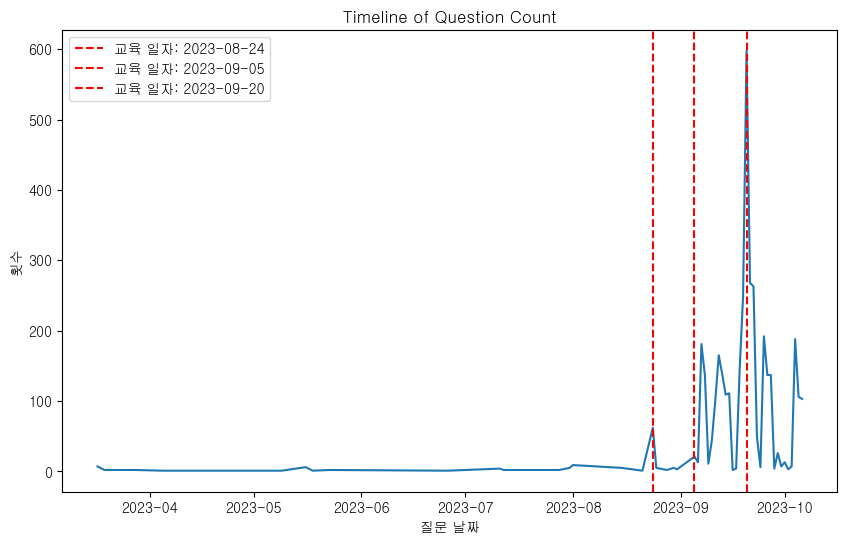

In [30]:

## 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=timeline_question_235, x='CreatedDatetime', y='count')

# 특정 세 날짜에 해당하는 세로선 추가
special_dates = ['2023-08-24', '2023-09-05', '2023-09-20']


for date in special_dates:
    date_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    plt.axvline(x=date_obj, color='red', linestyle='--', label=f'교육 일자: {date}')

# 그래프에 레이블 추가
plt.title('Timeline of Question Count')
plt.xlabel('질문 날짜')
plt.ylabel('횟수')
plt.legend()


<Axes: xlabel='CreatedDatetime', ylabel='count'>

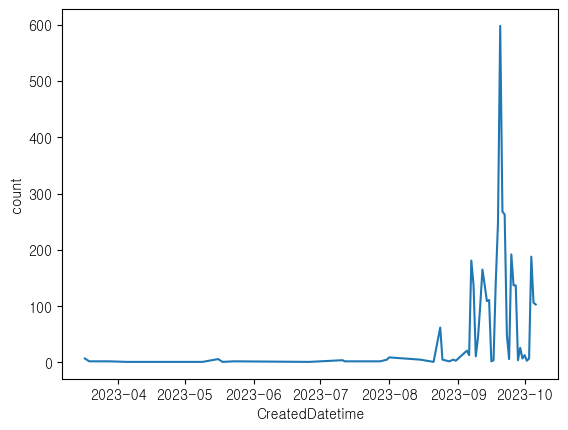

In [31]:
sns.lineplot(data=timeline_question_235, x='CreatedDatetime', y='count')

In [32]:
# datetime기준이 아닌 비교 결과로 묶어 웨비나 교육 전, 중, 후에 대한 분석
edu_235 = df_webinar_235.groupby('비교 결과').count().reset_index()[['비교 결과','Unnamed: 0']]
edu_all = df_webinar.groupby('비교 결과').count().reset_index()[['비교 결과','Unnamed: 0']]
edu_1 = df_webinar[df_webinar['라벨'] == 1].groupby('비교 결과').count().reset_index()[['비교 결과','Unnamed: 0']]

In [33]:
edu_235.rename(columns={'Unnamed: 0': 'count'}, inplace=True)
edu_all.rename(columns={'Unnamed: 0': 'count'}, inplace=True)
edu_1.rename(columns={'Unnamed: 0': 'count'}, inplace=True)

In [34]:
edu_all

,비교 결과,count
0,동일,1038
1,이전,652
2,이후,5594


In [35]:
edu_235

,비교 결과,count
0,동일,529
1,이전,140
2,이후,3001


In [36]:
edu_1

,비교 결과,count
0,동일,329
1,이전,189
2,이후,1478


In [37]:
df_edu = pd.merge(edu_1,edu_235, on='비교 결과')
df_edu = pd.merge(df_edu,edu_all, on='비교 결과')
df_edu

,비교 결과,count_x,count_y,count
0,동일,329,529,1038
1,이전,189,140,652
2,이후,1478,3001,5594


In [38]:
df_edu.rename(columns={'count_x':'label_1',
                       'count_y':'label_235',
                       'count':'all'}, inplace=True)
temp_row = df_edu.iloc[0].copy()
df_edu.iloc[0] = df_edu.iloc[1]  # 0번 row를 1번 row로 대체
df_edu.iloc[1] = temp_row  # 1번 row를 임시로 저장해둔 0번 row로 대체

df_edu

,비교 결과,label_1,label_235,all
0,이전,189,140,652
1,동일,329,529,1038
2,이후,1478,3001,5594


Text(0, 0.5, '질문 수')

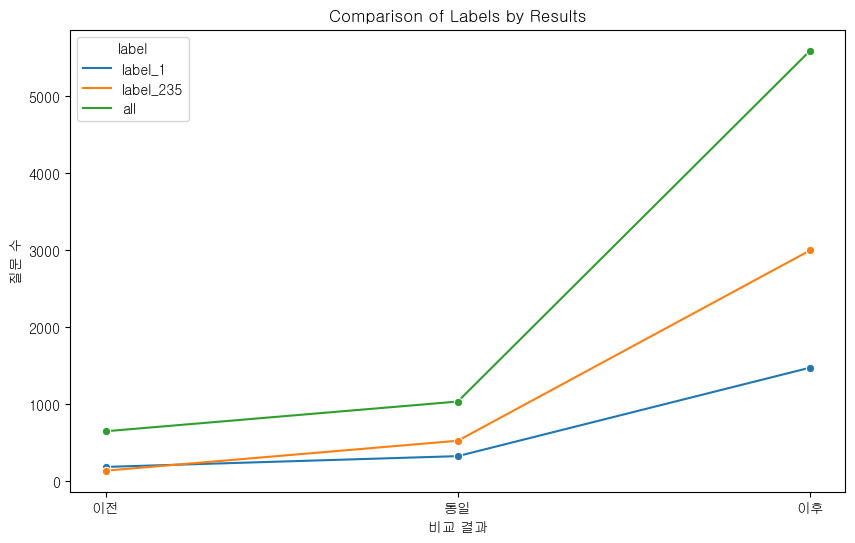

In [39]:

# 데이터프레임 변형
df_edu_melted = df_edu.melt(id_vars='비교 결과', var_name='label', value_name='질문 수')

# 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(x='비교 결과', y='질문 수', hue='label', data=df_edu_melted, marker='o', sort=False)

# 그래프에 레이블 추가
plt.title('Comparison of Labels by Results')
plt.xlabel('비교 결과')
plt.ylabel('질문 수')


In [40]:
df_webinar12 = pd.concat([webinar_1,webinar_2], ignore_index=True)
df_webinar12

,Unnamed: 0,CreatedDatetime,UserCode,Department,UserQuestion,Model,ResponseTime,교육일자,라벨
0,111703,2023-09-07 08:03:32.600576,3636,(광양)인사노무그룹 QSS섹션,대한민국명장선정으로 축하메세지 200자 이내로 작성해줘,gpt-35-turbo-16k,10,2023-09-05,0
1,111708,2023-09-07 08:05:00.477848,3636,(광양)인사노무그룹 QSS섹션,우수숙련기술자 선정으로 축하메세지 200자 이내로 작성해줘,gpt-35-turbo-16k,10,2023-09-05,0
2,111712,2023-09-07 08:06:01.594686,3638,자동차소재연구소 자동차소재표면연구그룹,아래 코딩의 문제를 해결해줘.\n\n코딩\n# calculate 함수에 의한 계산\...,gpt-35-turbo-16k,5,2023-09-05,5
3,111720,2023-09-07 08:08:42.420420,3640,(광양)제강부 제강기술개발섹션,나는 제강전문가야. 아르곤 버블링 시 기포의 크기를 다르게 했을경우 용강 교반능력의...,gpt-35-turbo-16k,15,2023-09-05,2
4,111723,2023-09-07 08:09:10.688764,3642,디지털혁신실 정보보호사무국 보안기획섹션,"내 질문에 하이퍼파라미터 ""beam_width=30"", ""Top_p=0.1"", ""T...",gpt-35-turbo-16k,17,2023-09-05,0
...,...,...,...,...,...,...,...,...,...
4836,137967,2023-09-27 05:17:02.458730,3827,광양생산부 산소공장,엑셀 조건부 서식 그 줄 행의 값이 1이 되면 그줄을 노란색으로 채우는 방법,gpt-35-turbo-16k,19,2023-08-24,5
4837,137968,2023-09-27 05:26:47.177877,3827,광양생산부 산소공장,엑셀 체크 박스 사용방법 알려줘,gpt-35-turbo-16k,25,2023-08-24,5
4838,137969,2023-09-27 05:39:56.681435,3827,광양생산부 산소공장,엑셀에 체크박스를 여러 행에 복사해서 붙여넣기,gpt-35-turbo-16k,10,2023-08-24,5
4839,137970,2023-09-27 05:44:31.935062,3827,광양생산부 산소공장,엑셀에서 각 체크 박스 연결방법,gpt-35-turbo-16k,22,2023-08-24,5


#### 이전, 동일, 이후 모두 가진 UserCode 추출 및 GPT 사용량, 질문 quality 추이 시각화 및 확인


In [41]:
df_webinar

,Unnamed: 0,CreatedDatetime,UserCode,Department,UserQuestion,Model,ResponseTime,교육일자,라벨,비교 결과
0,111703,2023-09-07,3636,(광양)인사노무그룹 QSS섹션,대한민국명장선정으로 축하메세지 200자 이내로 작성해줘,gpt-35-turbo-16k,10,2023-09-05,0,이후
1,111708,2023-09-07,3636,(광양)인사노무그룹 QSS섹션,우수숙련기술자 선정으로 축하메세지 200자 이내로 작성해줘,gpt-35-turbo-16k,10,2023-09-05,0,이후
2,111712,2023-09-07,3638,자동차소재연구소 자동차소재표면연구그룹,아래 코딩의 문제를 해결해줘.\n\n코딩\n# calculate 함수에 의한 계산\...,gpt-35-turbo-16k,5,2023-09-05,5,이후
3,111720,2023-09-07,3640,(광양)제강부 제강기술개발섹션,나는 제강전문가야. 아르곤 버블링 시 기포의 크기를 다르게 했을경우 용강 교반능력의...,gpt-35-turbo-16k,15,2023-09-05,2,이후
4,111723,2023-09-07,3642,디지털혁신실 정보보호사무국 보안기획섹션,"내 질문에 하이퍼파라미터 ""beam_width=30"", ""Top_p=0.1"", ""T...",gpt-35-turbo-16k,17,2023-09-05,0,이후
...,...,...,...,...,...,...,...,...,...,...
7279,146119,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,위 내용을 영어로 번역해주세요,gpt-35-turbo-16k,2,2023-09-20,4,이후
7280,146142,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,"DHL에서는 이 전화번호로 연락시, 수신되지 않는다고 합니다.",gpt-35-turbo-16k,2,2023-09-20,0,이후
7281,146154,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,"긴급히 확인요망""""을 영어로 표현해 주세요",gpt-35-turbo-16k,0,2023-09-20,4,이후
7282,146515,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,The department for deliveries is open 24/7,gpt-35-turbo-16k,1,2023-09-20,0,이후


In [42]:
df_usercode = df_webinar.groupby('UserCode')[['비교 결과']].sum()
df_usercode

,비교 결과
UserCode,
446,이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전...
494,이전이전이전이전이전이전이전이전이전이전이전이전이전이전이후이후
498,이전이전이전이전이전이전이후이후이후이후이후이후이후이후
1200,이전이전이전이전이전이전이전이전이전이전이전이전이전이전동일동일동일동일동일동일동일동일이후이후
1989,이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전이전...
...,...
5406,이후이후이후이후이후이후이후이후이후이후
5516,이후이후이후이후이후
5528,이후


In [43]:
df_usercode = df_usercode.reset_index()

In [44]:
def compare_str_split(text):
    text_list = [text[i:i+2] for i in range(0,len(text),2)]
    return list(set(text_list))

In [45]:
df_usercode['비교 결과'] = df_usercode['비교 결과'].apply(lambda x: compare_str_split(x))

In [46]:
df_usercode

,UserCode,비교 결과
0,446,"[이후, 이전, 동일]"
1,494,"[이후, 이전]"
2,498,"[이후, 이전]"
3,1200,"[이후, 이전, 동일]"
4,1989,"[이후, 이전, 동일]"
...,...,...
241,5406,[이후]
242,5516,[이후]
243,5528,[이후]
244,5590,[이후]


In [47]:
df_usercode[df_usercode['비교 결과'].apply(len) >= 2]

,UserCode,비교 결과
0,446,"[이후, 이전, 동일]"
1,494,"[이후, 이전]"
2,498,"[이후, 이전]"
3,1200,"[이후, 이전, 동일]"
4,1989,"[이후, 이전, 동일]"
...,...,...
209,5035,"[이후, 동일]"
210,5038,"[이후, 동일]"
211,5041,"[이후, 동일]"
212,5043,"[이후, 동일]"


In [48]:
list_temp = sum(df_usercode[(df_usercode['비교 결과'].apply(len) == 1)]['비교 결과'].to_list(),[])
set(list_temp)

{'이후'}

In [49]:
df_usercode[(df_usercode['비교 결과'].apply(len) == 1)]['UserCode']

9      3636
10     3638
11     3640
12     3642
13     3655
       ... 
241    5406
242    5516
243    5528
244    5590
245    5600
Name: UserCode, Length: 179, dtype: int64

In [50]:
df_usercode[(df_usercode['비교 결과'].apply(len) == 2)]['비교 결과'].to_list()

[['이후', '이전'],
 ['이후', '이전'],
 ['이후', '이전'],
 ['이후', '이전'],
 ['이후', '이전'],
 ['이후', '이전'],
 ['이후', '이전'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일'],
 ['이후', '동일']]

In [51]:
users = df_usercode[df_usercode['비교 결과'].apply(len) == 3].reset_index()
users

,index,UserCode,비교 결과
0,0,446,"[이후, 이전, 동일]"
1,3,1200,"[이후, 이전, 동일]"
2,4,1989,"[이후, 이전, 동일]"
3,5,2110,"[이후, 이전, 동일]"
4,6,2462,"[이후, 이전, 동일]"
5,7,2600,"[이후, 이전, 동일]"
6,8,3480,"[이후, 이전, 동일]"
7,23,3711,"[이후, 이전, 동일]"
8,29,3734,"[이후, 이전, 동일]"
9,56,3864,"[이후, 이전, 동일]"


In [52]:
df_bna = df_webinar[df_webinar['UserCode'].isin(users['UserCode'])]
df_bna

,Unnamed: 0,CreatedDatetime,UserCode,Department,UserQuestion,Model,ResponseTime,교육일자,라벨,비교 결과
5959,3504,2023-03-09,446,마케팅전략실,안녕,gpt-3.5,4,2023-08-24,1,이전
5960,3507,2023-03-09,446,마케팅전략실,너의 버전은 어떻게 되는거야 ?,gpt-3.5,6,2023-08-24,1,이전
5961,3509,2023-03-09,446,마케팅전략실,포스코홀딩스의 금일 기준 주가를 알려줘,gpt-3.5,8,2023-08-24,1,이전
5962,3512,2023-03-09,446,마케팅전략실,포스코홀딩스의 어제 주가는 얼마야 ?,gpt-3.5,6,2023-08-24,1,이전
5964,11018,2023-03-17,446,마케팅전략실,안녕,gpt-3.5,1,2023-08-24,1,이전
...,...,...,...,...,...,...,...,...,...,...
7279,146119,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,위 내용을 영어로 번역해주세요,gpt-35-turbo-16k,2,2023-09-20,4,이후
7280,146142,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,"DHL에서는 이 전화번호로 연락시, 수신되지 않는다고 합니다.",gpt-35-turbo-16k,2,2023-09-20,0,이후
7281,146154,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,"긴급히 확인요망""""을 영어로 표현해 주세요",gpt-35-turbo-16k,0,2023-09-20,4,이후
7282,146515,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,The department for deliveries is open 24/7,gpt-35-turbo-16k,1,2023-09-20,0,이후


In [53]:
df_bna_count = df_bna.groupby('비교 결과').count().reset_index()[['비교 결과','Unnamed: 0']]
df_bna_count

,비교 결과,Unnamed: 0
0,동일,446
1,이전,616
2,이후,210


In [54]:
df_bna_count.iloc[0], df_bna_count.iloc[1] = df_bna_count.iloc[1].copy(), df_bna_count.iloc[0].copy()
df_bna_count

,비교 결과,Unnamed: 0
0,이전,616
1,동일,446
2,이후,210


In [55]:
df_bna_count.rename(columns = {'Unnamed: 0':'all'}, inplace=True)

In [56]:
df_bna_2to5 = df_bna[df_bna['라벨'].isin([2,3,4,5])]
df_bna_2to5

,Unnamed: 0,CreatedDatetime,UserCode,Department,UserQuestion,Model,ResponseTime,교육일자,라벨,비교 결과
5968,11440,2023-03-17,446,마케팅전략실,액셀에서 필터를 걸고 나서 데이터를 추가 할때 주의해야하는 사항에 대해서 알려줘,gpt-3.5,20,2023-08-24,2,이전
5969,11448,2023-03-17,446,마케팅전략실,그러면 필터링 한 상태에서 데이터를 정확하게 추가하는 방법을 알려줘,gpt-3.5,18,2023-08-24,5,이전
5970,11465,2023-03-17,446,마케팅전략실,액셀 A:F행이 모두 빈칸일 경우 그 다음 텍스트가 나올 때까지 각각 행을 삭제하는...,gpt-3.5,16,2023-08-24,5,이전
5971,11473,2023-03-17,446,마케팅전략실,"코드를 실행하려면 VBA 창에서 해당 시트 모듈을 열고, 코드를 붙여넣은 후 실행하...",gpt-3.5,6,2023-08-24,5,이전
5972,11480,2023-03-17,446,마케팅전략실,개발 탭은 어디에 있어 ?,gpt-3.5,12,2023-08-24,2,이전
...,...,...,...,...,...,...,...,...,...,...
7275,145965,2023-10-06,4335,(광양)EIC기술부 SmartFactory섹션,"엑셀에서 min, max 변환 표준화를 하는 함수를 짜줘",gpt-4,14,2023-09-20,5,이후
7276,146058,2023-10-06,4335,(광양)EIC기술부 SmartFactory섹션,엑셀로 IQR 구하는 법 알려줘,gpt-4,17,2023-09-20,5,이후
7277,146105,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,다음의 내용을 영어 이메일로 작성해주세요,gpt-35-turbo-16k,6,2023-09-20,4,이후
7279,146119,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,위 내용을 영어로 번역해주세요,gpt-35-turbo-16k,2,2023-09-20,4,이후


In [57]:
df_bna_1 = df_bna[df_bna['라벨'] == 1]
df_bna_1

,Unnamed: 0,CreatedDatetime,UserCode,Department,UserQuestion,Model,ResponseTime,교육일자,라벨,비교 결과
5959,3504,2023-03-09,446,마케팅전략실,안녕,gpt-3.5,4,2023-08-24,1,이전
5960,3507,2023-03-09,446,마케팅전략실,너의 버전은 어떻게 되는거야 ?,gpt-3.5,6,2023-08-24,1,이전
5961,3509,2023-03-09,446,마케팅전략실,포스코홀딩스의 금일 기준 주가를 알려줘,gpt-3.5,8,2023-08-24,1,이전
5962,3512,2023-03-09,446,마케팅전략실,포스코홀딩스의 어제 주가는 얼마야 ?,gpt-3.5,6,2023-08-24,1,이전
5964,11018,2023-03-17,446,마케팅전략실,안녕,gpt-3.5,1,2023-08-24,1,이전
...,...,...,...,...,...,...,...,...,...,...
7240,142358,2023-10-04,4335,(광양)EIC기술부 SmartFactory섹션,고등학생에게는 어떻게 설명 할까,gpt-4,12,2023-09-20,1,이후
7241,142363,2023-10-04,4335,(광양)EIC기술부 SmartFactory섹션,"AI가 인간의 지능을 모방한다고 하였는데, 인간의 지능을 뛰어넘을 수는 없는걸까?",gpt-4,27,2023-09-20,1,이후
7242,142369,2023-10-04,4335,(광양)EIC기술부 SmartFactory섹션,너의 생각은 어때?,gpt-4,8,2023-09-20,1,이후
7243,142843,2023-10-04,4335,(광양)EIC기술부 SmartFactory섹션,AI 정의를 명확하게 설명해줘,gpt-4,22,2023-09-20,1,이후


In [58]:
df_bna_count2to5 = df_bna_2to5.groupby('비교 결과').count().reset_index()[['비교 결과','Unnamed: 0']]
df_bna_count2to5.iloc[0], df_bna_count2to5.iloc[1] = df_bna_count2to5.iloc[1].copy(), df_bna_count2to5.iloc[0].copy()
df_bna_count2to5.rename(columns = {'Unnamed: 0':'lable_2to5'}, inplace=True)
df_bna_count2to5

,비교 결과,lable_2to5
0,이전,398
1,동일,224
2,이후,132


In [59]:
df_bna_count1 = df_bna_1.groupby('비교 결과').count().reset_index()[['비교 결과','Unnamed: 0']]
df_bna_count1.iloc[0], df_bna_count1.iloc[1] = df_bna_count1.iloc[1].copy(), df_bna_count1.iloc[0].copy()
df_bna_count1.rename(columns = {'Unnamed: 0':'lable_1'}, inplace=True)
df_bna_count1

,비교 결과,lable_1
0,이전,161
1,동일,155
2,이후,40


In [60]:
df_bna_count = pd.merge(df_bna_count,df_bna_count1,on='비교 결과')
df_bna_count = pd.merge(df_bna_count,df_bna_count2to5,on='비교 결과')
df_bna_count

,비교 결과,all,lable_1,lable_2to5
0,이전,616,161,398
1,동일,446,155,224
2,이후,210,40,132


In [61]:
df_webinar.sort_values(by='CreatedDatetime',ascending=True)

,Unnamed: 0,CreatedDatetime,UserCode,Department,UserQuestion,Model,ResponseTime,교육일자,라벨,비교 결과
5959,3504,2023-03-09,446,마케팅전략실,안녕,gpt-3.5,4,2023-08-24,1,이전
5962,3512,2023-03-09,446,마케팅전략실,포스코홀딩스의 어제 주가는 얼마야 ?,gpt-3.5,6,2023-08-24,1,이전
5960,3507,2023-03-09,446,마케팅전략실,너의 버전은 어떻게 되는거야 ?,gpt-3.5,6,2023-08-24,1,이전
5961,3509,2023-03-09,446,마케팅전략실,포스코홀딩스의 금일 기준 주가를 알려줘,gpt-3.5,8,2023-08-24,1,이전
6359,4077,2023-03-10,498,글로벌품질서비스실,한국에서 전쟁이 나면 어떻게 해야해?,gpt-3.5,13,2023-09-05,1,이전
...,...,...,...,...,...,...,...,...,...,...
5898,146157,2023-10-06,4708,(광양)제강부 2연주공장,제주도 관광객들이 많이 찾는 대표적인 관광지와 주변 맛집을 이동거리를 고려하여 매칭...,gpt-4,18,2023-08-24,1,이후
5897,146108,2023-10-06,5590,(포항)설비소통섹션,분쟁 신고 후 절차와 기간은 어떻게 되는 가요?,gpt-35-turbo-16k,22,2023-09-20,1,이후
5896,146069,2023-10-06,4974,강재연구소 에너지조선연구그룹,"C++ 함수중에 """"FindFile""""의 기능에 대하여 설명해줘",gpt-35-turbo-16k,12,2023-09-20,2,이후
5904,146200,2023-10-06,4663,전기로사업추진TF팀,저는 철강업체 엔지니어입니다. 저탄소제품 생산을 위한 공장을 신설하려고 하는데 공장...,gpt-35-turbo-16k,22,2023-09-05,2,이후


In [62]:
educated_date = df_webinar.groupby(['UserCode','교육일자']).count()[['Unnamed: 0']].reset_index()[['UserCode','교육일자']]
educated_date

,UserCode,교육일자
0,446,2023-08-24
1,494,2023-09-05
2,498,2023-09-05
3,1200,2023-09-05
4,1989,2023-08-24
...,...,...
241,5406,2023-08-24
242,5516,2023-08-24
243,5528,2023-08-24
244,5590,2023-09-20


In [63]:
df_webinar.groupby(['UserCode']).count()[['Unnamed: 0']]

,Unnamed: 0
UserCode,
446,68
494,16
498,14
1200,24
1989,60
...,...
5406,10
5516,5
5528,1


In [64]:
df_ratio = df_webinar[df_webinar['라벨'].isin([0,2,3,4,5])].groupby(['UserCode','비교 결과']).count().reset_index()[['UserCode','비교 결과','Unnamed: 0']]
df_ratio

,UserCode,비교 결과,Unnamed: 0
0,446,동일,18
1,446,이전,23
2,446,이후,2
3,494,이후,2
4,498,이전,1
...,...,...,...
302,5406,이후,10
303,5516,이후,4
304,5528,이후,1
305,5590,이후,3


In [65]:
df_ratio = df_ratio[df_ratio['UserCode'].isin(users['UserCode'])]

In [66]:
df_pivot = df_ratio.pivot(index='UserCode',columns='비교 결과',values='Unnamed: 0')
df_ratio_piv = df_pivot.reset_index()

In [67]:
df_ratio_piv

비교 결과,UserCode,동일,이전,이후
0,446,18.0,23.0,2.0
1,1200,3.0,6.0,2.0
2,1989,7.0,31.0,6.0
3,2110,1.0,249.0,9.0
4,2462,2.0,2.0,8.0
5,2600,44.0,1.0,8.0
6,3480,25.0,9.0,5.0
7,3711,9.0,NaN,NaN
8,3734,5.0,5.0,8.0
9,3864,22.0,9.0,2.0


In [68]:
df_ratio_piv = df_ratio_piv.dropna().reset_index()
df_ratio_piv = df_ratio_piv.drop('index',axis=1)


In [69]:
# df_ratio_piv = df_ratio_piv.drop('level_0', axis=1)
df_ratio_piv

비교 결과,UserCode,동일,이전,이후
0,446,18.0,23.0,2.0
1,1200,3.0,6.0,2.0
2,1989,7.0,31.0,6.0
3,2110,1.0,249.0,9.0
4,2462,2.0,2.0,8.0
5,2600,44.0,1.0,8.0
6,3480,25.0,9.0,5.0
7,3734,5.0,5.0,8.0
8,3864,22.0,9.0,2.0
9,3887,16.0,44.0,43.0


In [70]:
df_ratio_piv = pd.merge(df_ratio_piv,educated_date[educated_date['UserCode'].isin(users['UserCode'])],on='UserCode')
df_ratio_piv

,UserCode,동일,이전,이후,교육일자
0,446,18.0,23.0,2.0,2023-08-24
1,1200,3.0,6.0,2.0,2023-09-05
2,1989,7.0,31.0,6.0,2023-08-24
3,2110,1.0,249.0,9.0,2023-09-05
4,2462,2.0,2.0,8.0,2023-09-05
5,2600,44.0,1.0,8.0,2023-08-24
6,3480,25.0,9.0,5.0,2023-09-05
7,3734,5.0,5.0,8.0,2023-09-20
8,3864,22.0,9.0,2.0,2023-09-20
9,3887,16.0,44.0,43.0,2023-09-20


In [71]:
df_ratio_piv = df_ratio_piv[['UserCode','이전','동일','이후','교육일자']]
df_ratio_piv

,UserCode,이전,동일,이후,교육일자
0,446,23.0,18.0,2.0,2023-08-24
1,1200,6.0,3.0,2.0,2023-09-05
2,1989,31.0,7.0,6.0,2023-08-24
3,2110,249.0,1.0,9.0,2023-09-05
4,2462,2.0,2.0,8.0,2023-09-05
5,2600,1.0,44.0,8.0,2023-08-24
6,3480,9.0,25.0,5.0,2023-09-05
7,3734,5.0,5.0,8.0,2023-09-20
8,3864,9.0,22.0,2.0,2023-09-20
9,3887,44.0,16.0,43.0,2023-09-20


In [72]:
date_format = '%Y-%m-%d'

START_DATE = datetime.datetime.strptime('2023-03-09', date_format)
END_DATE = datetime.datetime.strptime('2023-10-06', date_format)


def usage_ratio_before(row):
    edu_date = row['교육일자']
    diff_dates = edu_date - START_DATE
    return row['이전'] / diff_dates.days

def usage_ratio_after(row):
    edu_date = row['교육일자']
    diff_dates = END_DATE - edu_date
    return row['이후'] / diff_dates.days

In [73]:
df_ratio_piv['이전 비율'] = df_ratio_piv.apply(usage_ratio_before, axis=1).round(3)
df_ratio_piv['이후 비율'] = df_ratio_piv.apply(usage_ratio_after, axis=1).round(3)

C:\Users\piai\AppData\Local\Temp\ipykernel_17664\691069724.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratio_piv['이전 비율'] = df_ratio_piv.apply(usage_ratio_before, axis=1).round(3)
C:\Users\piai\AppData\Local\Temp\ipykernel_17664\691069724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratio_piv['이후 비율'] = df_ratio_piv.apply(usage_ratio_after, axis=1).round(3)


In [74]:
df_ratio_piv

,UserCode,이전,동일,이후,교육일자,이전 비율,이후 비율
0,446,23.0,18.0,2.0,2023-08-24,0.137,0.047
1,1200,6.0,3.0,2.0,2023-09-05,0.033,0.065
2,1989,31.0,7.0,6.0,2023-08-24,0.185,0.140
3,2110,249.0,1.0,9.0,2023-09-05,1.383,0.290
4,2462,2.0,2.0,8.0,2023-09-05,0.011,0.258
5,2600,1.0,44.0,8.0,2023-08-24,0.006,0.186
6,3480,9.0,25.0,5.0,2023-09-05,0.050,0.161
7,3734,5.0,5.0,8.0,2023-09-20,0.026,0.500
8,3864,9.0,22.0,2.0,2023-09-20,0.046,0.125
9,3887,44.0,16.0,43.0,2023-09-20,0.226,2.688


In [75]:
df_ratio_piv['이전 비율'].mean().round(3)

0.123

In [76]:
df_ratio_piv['이후 비율'].mean().round(3)

0.432

In [77]:
df_ratio_bba = df_ratio_piv[df_ratio_piv['이전 비율'] > df_ratio_piv['이후 비율']]
df_ratio_bla = df_ratio_piv[df_ratio_piv['이전 비율'] < df_ratio_piv['이후 비율']]

In [78]:
df_ratio_bba


,UserCode,이전,동일,이후,교육일자,이전 비율,이후 비율
0,446,23.0,18.0,2.0,2023-08-24,0.137,0.047
2,1989,31.0,7.0,6.0,2023-08-24,0.185,0.140
3,2110,249.0,1.0,9.0,2023-09-05,1.383,0.290


In [79]:
df_ratio_bla

,UserCode,이전,동일,이후,교육일자,이전 비율,이후 비율
1,1200,6.0,3.0,2.0,2023-09-05,0.033,0.065
4,2462,2.0,2.0,8.0,2023-09-05,0.011,0.258
5,2600,1.0,44.0,8.0,2023-08-24,0.006,0.186
6,3480,9.0,25.0,5.0,2023-09-05,0.050,0.161
7,3734,5.0,5.0,8.0,2023-09-20,0.026,0.500
8,3864,9.0,22.0,2.0,2023-09-20,0.046,0.125
9,3887,44.0,16.0,43.0,2023-09-20,0.226,2.688
10,3917,22.0,14.0,5.0,2023-09-20,0.113,0.312
11,4165,16.0,3.0,7.0,2023-09-20,0.082,0.438
12,4208,5.0,15.0,4.0,2023-09-20,0.026,0.250


In [80]:
df_ratio_bba.apply(len), df_ratio_bla.apply(len)


(UserCode    3
 이전          3
 동일          3
 이후          3
 교육일자        3
 이전 비율       3
 이후 비율       3
 dtype: int64,
 UserCode    17
 이전          17
 동일          17
 이후          17
 교육일자        17
 이전 비율       17
 이후 비율       17
 dtype: int64)

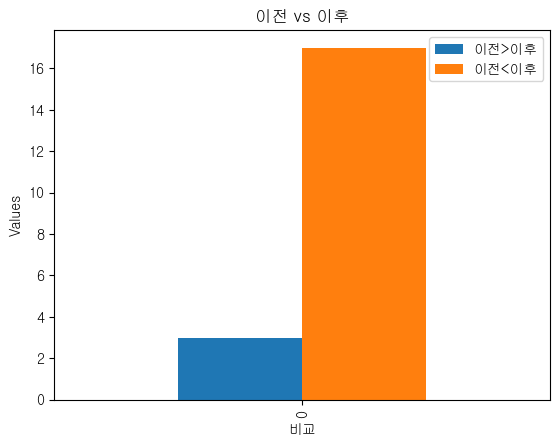

In [81]:
df_temp = pd.DataFrame(data={'이전>이후':[3],
                        '이전<이후':[17]})

df_temp.plot(kind='bar')
plt.title('이전 vs 이후')
plt.ylabel('Values')
plt.xlabel('비교')
plt.show()

### 라벨별 분포 시각화
 비교 결과 컬럼에서 이전, 동일, 이후 값을모두 가진 사용자들의 라벨 비교 및 시각화

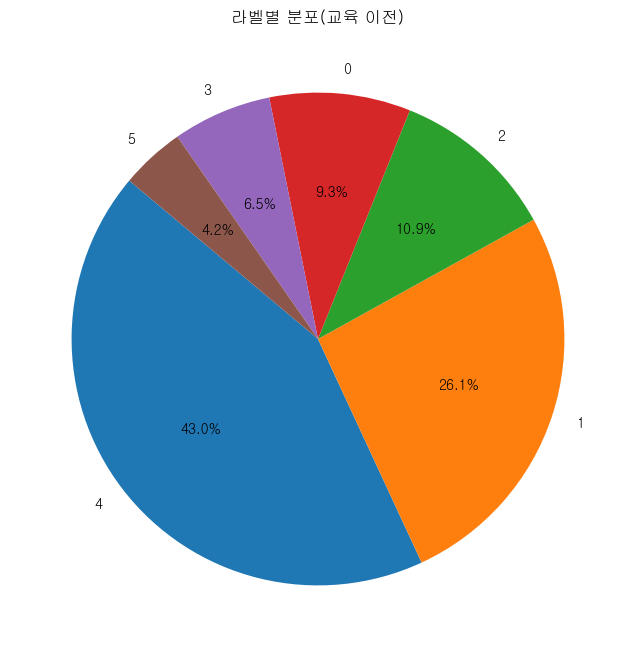

In [82]:
a = df_webinar
a = a[a['UserCode'].isin(users['UserCode'])&(a['비교 결과']=='이전')]

label_counts = a['라벨'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('라벨별 분포(교육 이전)')
plt.show()

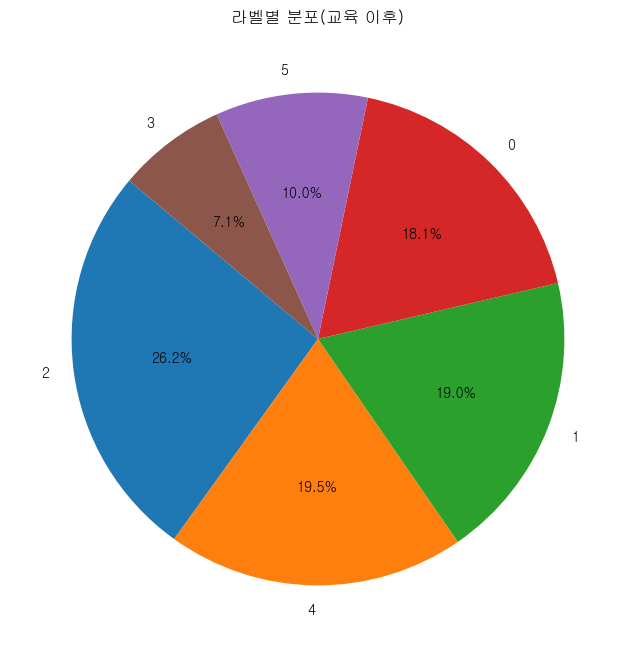

In [83]:
a = df_webinar
a = a[a['UserCode'].isin(users['UserCode'])&(a['비교 결과']=='이후')]

label_counts = a['라벨'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('라벨별 분포(교육 이후)')
plt.show()

In [84]:
user_list = users['UserCode'].to_list()
user_list

[446,
 1200,
 1989,
 2110,
 2462,
 2600,
 3480,
 3711,
 3734,
 3864,
 3887,
 3917,
 4165,
 4208,
 4220,
 4335,
 4497,
 4591,
 4667,
 4777,
 4835,
 4903,
 4908,
 4919]

In [85]:
df_webinar[df_webinar['UserCode'].isin(user_list)&(df_webinar['라벨']!=1)].to_excel('전중후다한사람질문퀄리티보자1.xlsx')

In [86]:
bna = df_webinar[df_webinar['UserCode'].isin(user_list)]

In [87]:
bna.groupby('UserCode').count()[['Unnamed: 0']].reset_index().sort_values(by='Unnamed: 0', ascending=False).head()

,UserCode,Unnamed: 0
3,2110,278
5,2600,115
10,3887,112
0,446,68
6,3480,66


In [88]:
bna_top_5_code = bna.groupby('UserCode').count()[['Unnamed: 0']].reset_index().sort_values(by='Unnamed: 0', ascending=False).head()['UserCode'].to_list()

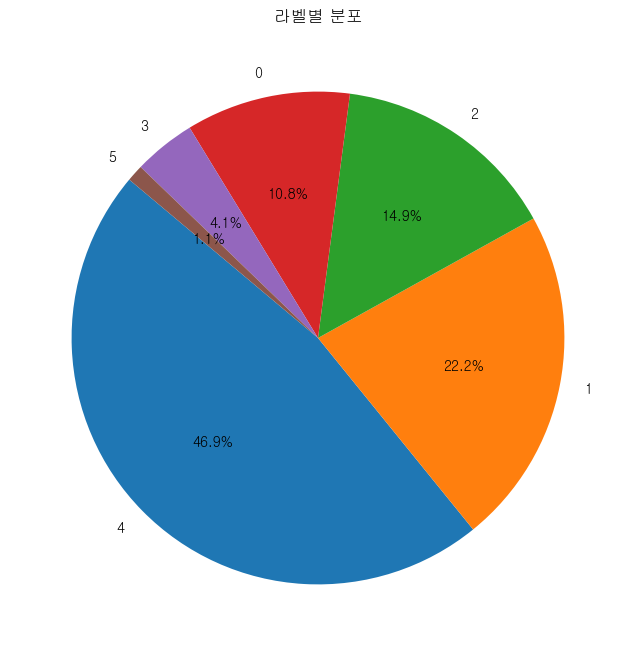

In [89]:
a = df_webinar[df_webinar['UserCode'].isin(bna_top_5_code) & df_webinar['라벨'].isin([0,1,2,3,4,5])]

label_counts = a['라벨'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('라벨별 분포')
plt.show()

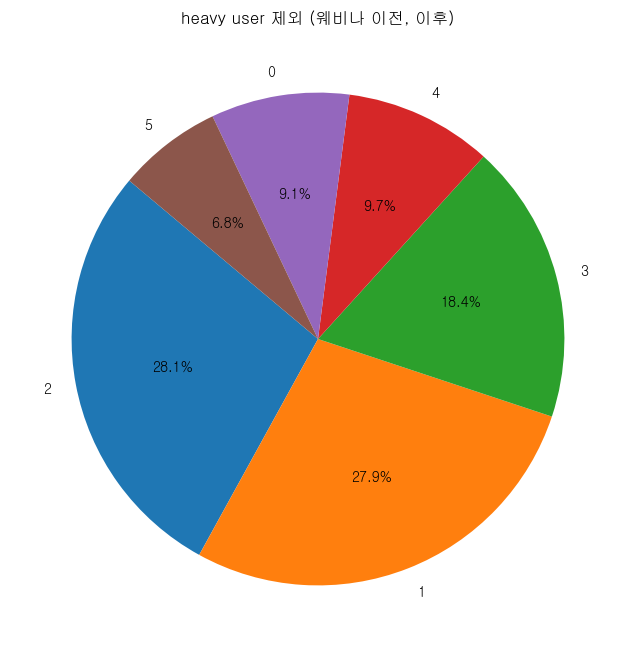

In [90]:
a = df_webinar[~df_webinar['UserCode'].isin(bna_top_5_code) & df_webinar['라벨'].isin([0,1,2,3,4,5])]

label_counts = a['라벨'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('heavy user 제외 (웨비나 이전, 이후)')
plt.show()

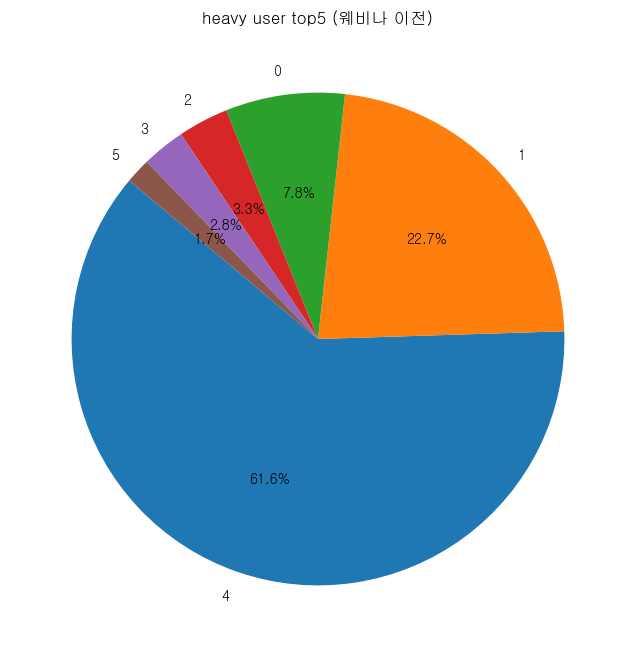

In [91]:
a = df_webinar[df_webinar['UserCode'].isin(bna_top_5_code) & df_webinar['라벨'].isin([0,1,2,3,4,5]) & (df_webinar['비교 결과'] == '이전')]

label_counts = a['라벨'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('heavy user top5 (웨비나 이전)')
plt.show()

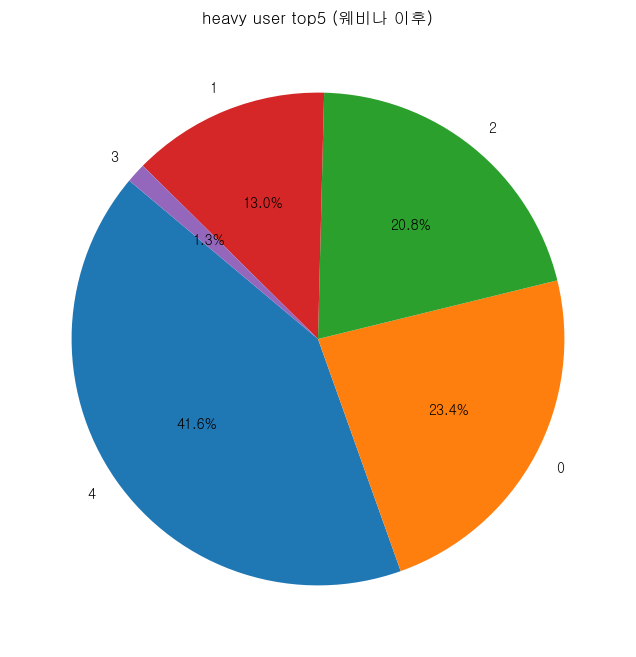

In [92]:
a = df_webinar[df_webinar['UserCode'].isin(bna_top_5_code) & df_webinar['라벨'].isin([0,1,2,3,4,5]) & (df_webinar['비교 결과'] == '이후')]

label_counts = a['라벨'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('heavy user top5 (웨비나 이후)')
plt.show()

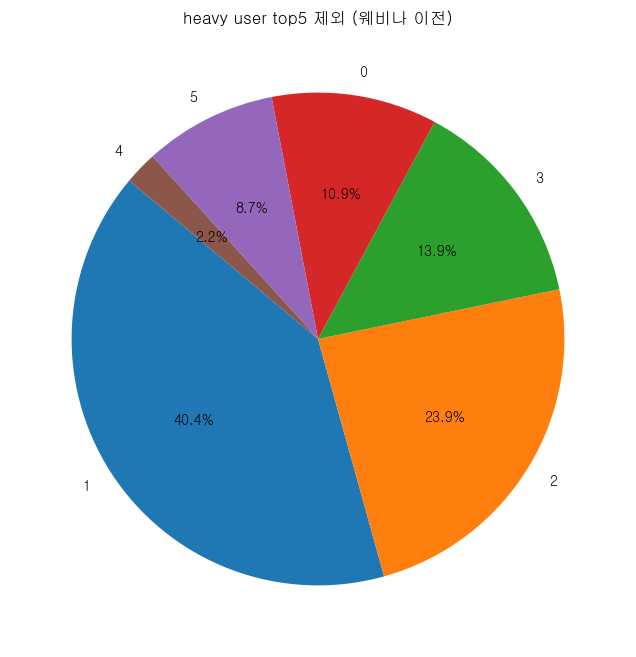

In [93]:
a = df_webinar[~df_webinar['UserCode'].isin(bna_top_5_code) & df_webinar['라벨'].isin([0,1,2,3,4,5]) & (df_webinar['비교 결과'] == '이전')]

label_counts = a['라벨'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('heavy user top5 제외 (웨비나 이전)')
plt.show()

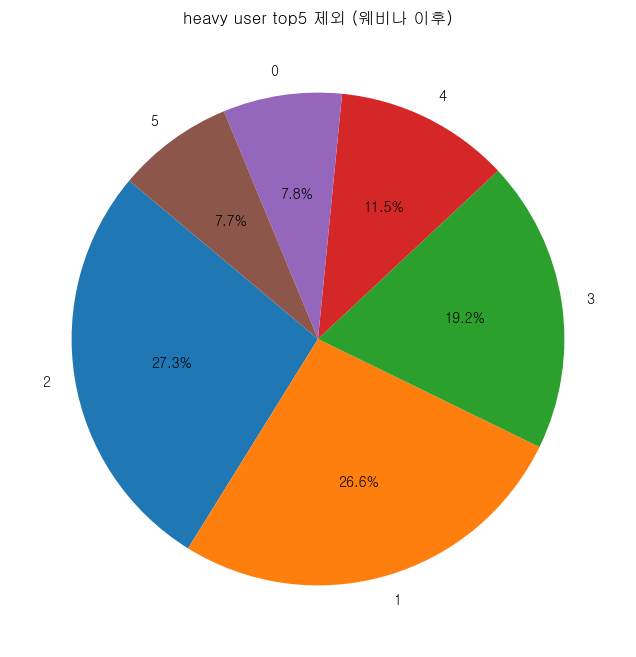

In [94]:
a = df_webinar[~df_webinar['UserCode'].isin(bna_top_5_code) & df_webinar['라벨'].isin([0,1,2,3,4,5]) & (df_webinar['비교 결과'] == '이후')]

label_counts = a['라벨'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('heavy user top5 제외 (웨비나 이후)')
plt.show()

### 교육 일자 별 사용자 이름 추출 및 해당 사용자들 웨비나 교육 전후 비교


In [95]:
df_webinar

,Unnamed: 0,CreatedDatetime,UserCode,Department,UserQuestion,Model,ResponseTime,교육일자,라벨,비교 결과
0,111703,2023-09-07,3636,(광양)인사노무그룹 QSS섹션,대한민국명장선정으로 축하메세지 200자 이내로 작성해줘,gpt-35-turbo-16k,10,2023-09-05,0,이후
1,111708,2023-09-07,3636,(광양)인사노무그룹 QSS섹션,우수숙련기술자 선정으로 축하메세지 200자 이내로 작성해줘,gpt-35-turbo-16k,10,2023-09-05,0,이후
2,111712,2023-09-07,3638,자동차소재연구소 자동차소재표면연구그룹,아래 코딩의 문제를 해결해줘.\n\n코딩\n# calculate 함수에 의한 계산\...,gpt-35-turbo-16k,5,2023-09-05,5,이후
3,111720,2023-09-07,3640,(광양)제강부 제강기술개발섹션,나는 제강전문가야. 아르곤 버블링 시 기포의 크기를 다르게 했을경우 용강 교반능력의...,gpt-35-turbo-16k,15,2023-09-05,2,이후
4,111723,2023-09-07,3642,디지털혁신실 정보보호사무국 보안기획섹션,"내 질문에 하이퍼파라미터 ""beam_width=30"", ""Top_p=0.1"", ""T...",gpt-35-turbo-16k,17,2023-09-05,0,이후
...,...,...,...,...,...,...,...,...,...,...
7279,146119,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,위 내용을 영어로 번역해주세요,gpt-35-turbo-16k,2,2023-09-20,4,이후
7280,146142,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,"DHL에서는 이 전화번호로 연락시, 수신되지 않는다고 합니다.",gpt-35-turbo-16k,2,2023-09-20,0,이후
7281,146154,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,"긴급히 확인요망""""을 영어로 표현해 주세요",gpt-35-turbo-16k,0,2023-09-20,4,이후
7282,146515,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,The department for deliveries is open 24/7,gpt-35-turbo-16k,1,2023-09-20,0,이후


In [96]:
df_webinar['라벨'].value_counts()

라벨
1      1996
2      1962
3      1246
4       944
0       672
5       462
3,4       1
2,3       1
Name: count, dtype: int64

In [101]:
df_users_edu = df_webinar[['UserCode','교육일자']].drop_duplicates().reset_index()

In [103]:
df_users_edu.drop(columns='index', inplace=True)
df_users_edu

,UserCode,교육일자
0,3636,2023-09-05
1,3638,2023-09-05
2,3640,2023-09-05
3,3642,2023-09-05
4,3655,2023-08-24
...,...,...
241,4165,2023-09-20
242,4335,2023-09-20
243,4591,2023-09-20
244,4777,2023-09-20


In [104]:
df_edu_0824 = df_users_edu[df_users_edu['교육일자'] == '2023-08-24']
df_edu_0905 = df_users_edu[df_users_edu['교육일자'] == '2023-09-05']
df_edu_0920 = df_users_edu[df_users_edu['교육일자'] == '2023-09-20']

In [105]:
df_edu_0824

,UserCode,교육일자
4,3655,2023-08-24
5,3656,2023-08-24
7,3668,2023-08-24
20,3744,2023-08-24
24,3772,2023-08-24
...,...,...
212,5528,2023-08-24
214,5600,2023-08-24
215,446,2023-08-24
233,1989,2023-08-24


In [106]:
df_edu_0905

,UserCode,교육일자
0,3636,2023-09-05
1,3638,2023-09-05
2,3640,2023-09-05
3,3642,2023-09-05
6,3665,2023-09-05
...,...,...
217,1200,2023-09-05
232,498,2023-09-05
234,2110,2023-09-05
235,2462,2023-09-05


In [107]:
df_edu_0920

,UserCode,교육일자
147,4936,2023-09-20
148,4944,2023-09-20
149,4949,2023-09-20
150,4951,2023-09-20
151,4954,2023-09-20
...,...,...
241,4165,2023-09-20
242,4335,2023-09-20
243,4591,2023-09-20
244,4777,2023-09-20


In [109]:
df_edu_0824_temp = df_webinar[df_webinar['UserCode'].isin(df_edu_0824['UserCode'])]
df_edu_0905_temp = df_webinar[df_webinar['UserCode'].isin(df_edu_0905['UserCode'])]
df_edu_0920_temp = df_webinar[df_webinar['UserCode'].isin(df_edu_0920['UserCode'])]


In [114]:
df_edu_0824_temp

,Unnamed: 0,CreatedDatetime,UserCode,Department,UserQuestion,Model,ResponseTime,교육일자,라벨,비교 결과
9,111764,2023-09-07,3655,(포항)인사노무그룹 교육노무섹션,"내용 가다듬어 주세요.\n팀장님, 24년 직원대의기구 소통간담회비 예산 수립관련하여...",gpt-35-turbo-16k,7,2023-08-24,3,이후
10,111765,2023-09-07,3656,(광양)제강부 1제강공장,엑셀함수에서 여러열을 지정하려면,gpt-35-turbo-16k,7,2023-08-24,5,이후
11,111772,2023-09-07,3655,(포항)인사노무그룹 교육노무섹션,"내용 가다듬어 주세요.\n팀장님, 24년 직원대의기구 소통간담회비 예산 수립관련하여...",gpt-35-turbo-16k,10,2023-08-24,3,이후
12,111777,2023-09-07,3656,(광양)제강부 1제강공장,이전 시트의 여러열과 하나의 행을 지정하려면?,gpt-35-turbo-16k,10,2023-08-24,3,이후
13,111780,2023-09-07,3656,(광양)제강부 1제강공장,이전 시트의 여러열과 하나의 행에서 글자를 복사하려면?,gpt-35-turbo-16k,11,2023-08-24,3,이후
...,...,...,...,...,...,...,...,...,...,...
6828,109493,2023-08-30,1989,(포항)행정지원그룹,사고를 반복하지 않기 위해 사고가 발생한 날을 기념일로 지정하려고 해._x000D_...,gpt-3.5,12,2023-08-24,3,이후
6829,109756,2023-08-31,2600,(광양)노재그룹,"내질문은 하이퍼파라미터 Top p= 0.01, Temperature= 0.1, Be...",gpt-3.5,35,2023-08-24,2,이후
6830,109765,2023-08-31,2600,(광양)노재그룹,"내질문은 하이퍼파라미터 Top p= 0.01, Temperature= 0.1, Be...",gpt-3.5,24,2023-08-24,2,이후
6831,109768,2023-08-31,2600,(광양)노재그룹,"내질문은 하이퍼파라미터 Top p= 0.01, Temperature= 0.1, Be...",gpt-3.5,32,2023-08-24,2,이후


In [111]:
df_edu_0905_temp

,Unnamed: 0,CreatedDatetime,UserCode,Department,UserQuestion,Model,ResponseTime,교육일자,라벨,비교 결과
0,111703,2023-09-07,3636,(광양)인사노무그룹 QSS섹션,대한민국명장선정으로 축하메세지 200자 이내로 작성해줘,gpt-35-turbo-16k,10,2023-09-05,0,이후
1,111708,2023-09-07,3636,(광양)인사노무그룹 QSS섹션,우수숙련기술자 선정으로 축하메세지 200자 이내로 작성해줘,gpt-35-turbo-16k,10,2023-09-05,0,이후
2,111712,2023-09-07,3638,자동차소재연구소 자동차소재표면연구그룹,아래 코딩의 문제를 해결해줘.\n\n코딩\n# calculate 함수에 의한 계산\...,gpt-35-turbo-16k,5,2023-09-05,5,이후
3,111720,2023-09-07,3640,(광양)제강부 제강기술개발섹션,나는 제강전문가야. 아르곤 버블링 시 기포의 크기를 다르게 했을경우 용강 교반능력의...,gpt-35-turbo-16k,15,2023-09-05,2,이후
4,111723,2023-09-07,3642,디지털혁신실 정보보호사무국 보안기획섹션,"내 질문에 하이퍼파라미터 ""beam_width=30"", ""Top_p=0.1"", ""T...",gpt-35-turbo-16k,17,2023-09-05,0,이후
...,...,...,...,...,...,...,...,...,...,...
6911,111575,2023-09-07,498,글로벌품질서비스실,아래 내용 영어로 번역해줘,gpt-3.5,537,2023-09-05,4,이후
6912,111576,2023-09-07,498,글로벌품질서비스실,안녕하세요 저는 김준환 입니다._x000D_\n저는 포스코에서 제품인증 담당을 하고...,gpt-3.5,23,2023-09-05,0,이후
6913,111579,2023-09-07,498,글로벌품질서비스실,아래내용 영어로 번역 해줘 안녕하세요 저는 김준환 입니다._x000D_\n저는...,gpt-3.5,2,2023-09-05,4,이후
6914,111582,2023-09-07,498,글로벌품질서비스실,영어로 번역해줘 _x000D_\n인증관련 일정은 아래와 같습니다. _x000D_...,gpt-3.5,6,2023-09-05,4,이후


In [112]:
df_edu_0920_temp

,Unnamed: 0,CreatedDatetime,UserCode,Department,UserQuestion,Model,ResponseTime,교육일자,라벨,비교 결과
2400,126676,2023-09-20,4936,(광양)생산기술부 생산관제섹션,일반 GPT 사용방법 요약,gpt-35-turbo-16k,19,2023-09-20,1,동일
2403,126680,2023-09-20,4936,(광양)생산기술부 생산관제섹션,POSCO그룹 2030 비젼,gpt-35-turbo-16k,22,2023-09-20,1,동일
2446,126952,2023-09-20,4944,자동차소재연구소 자동차소재표면연구그룹,melatonin의 이미지를 보여줘,gpt-35-turbo-16k,2,2023-09-20,0,동일
2447,126961,2023-09-20,4944,자동차소재연구소 자동차소재표면연구그룹,선박 건조 시 사용되는 강재의 종류와 특징,gpt-35-turbo-16k,15,2023-09-20,2,동일
2452,127000,2023-09-20,4944,자동차소재연구소 자동차소재표면연구그룹,서울에서 집의 월세를 빨리 내보낼 수 있는 방법을 알려줘,gpt-35-turbo-16k,22,2023-09-20,1,동일
...,...,...,...,...,...,...,...,...,...,...
7279,146119,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,위 내용을 영어로 번역해주세요,gpt-35-turbo-16k,2,2023-09-20,4,이후
7280,146142,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,"DHL에서는 이 전화번호로 연락시, 수신되지 않는다고 합니다.",gpt-35-turbo-16k,2,2023-09-20,0,이후
7281,146154,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,"긴급히 확인요망""""을 영어로 표현해 주세요",gpt-35-turbo-16k,0,2023-09-20,4,이후
7282,146515,2023-10-06,3887,글로벌품질서비스실 품질기획그룹 제품인증섹션,The department for deliveries is open 24/7,gpt-35-turbo-16k,1,2023-09-20,0,이후


In [120]:
user_count_by_date = df_edu_0824_temp.groupby('CreatedDatetime')[['UserCode']].count()
user_count_by_date.rename(columns={'UserCode':'count'},inplace=True)
user_count_by_date

,count
CreatedDatetime,
2023-03-09,4
2023-03-17,16
2023-03-22,3
2023-03-28,3
2023-03-30,16
...,...
2023-10-01,12
2023-10-03,7
2023-10-04,85


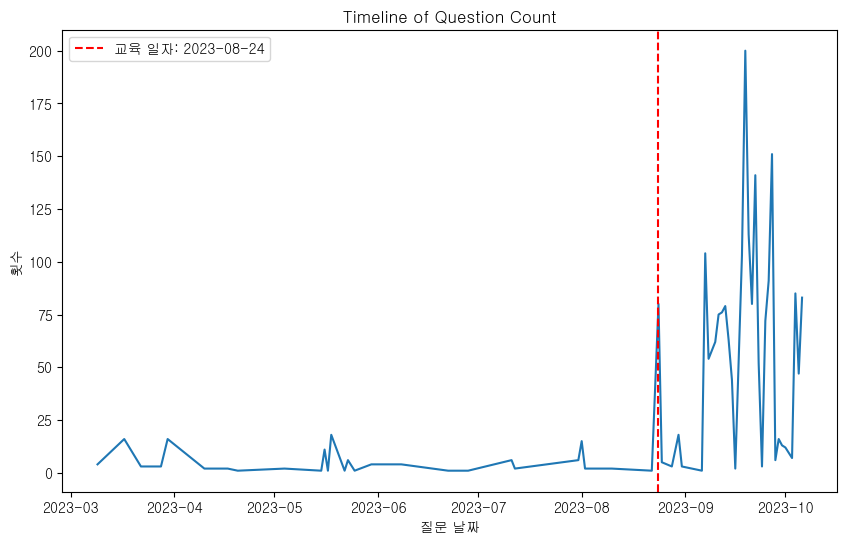

In [122]:
user_count_by_date = df_edu_0824_temp.groupby('CreatedDatetime')[['UserCode']].count()
user_count_by_date.rename(columns={'UserCode':'count'},inplace=True)

## 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=user_count_by_date, x='CreatedDatetime', y='count')

date = '2023-08-24'

date_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
plt.axvline(x=date_obj, color='red', linestyle='--', label=f'교육 일자: {date}')

# 그래프에 레이블 추가
plt.title('Timeline of Question Count')
plt.xlabel('질문 날짜')
plt.ylabel('횟수')
plt.legend()


In [125]:
user_count_by_date = df_edu_0905_temp.groupby('CreatedDatetime')[['UserCode']].count()
user_count_by_date.rename(columns={'UserCode':'count'},inplace=True)


date = '2023-09-05'
date_range = pd.date_range(start='2023-03-01', end='2023-10-03')
weekend_dates = date_range[date_range.dayofweek.isin([5, 6])]
weekend_dates_str = weekend_dates.strftime('%Y-%m-%d')

date_to_drop = [date] + weekend_dates_str

user_count_by_date = user_count_by_date.drop(date_to_drop)


## 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=user_count_by_date, x='CreatedDatetime', y='count')


date_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
plt.axvline(x=date_obj, color='red', linestyle='--', label=f'교육 일자: {date}')

# 그래프에 레이블 추가
plt.title('Timeline of Question Count')
plt.xlabel('질문 날짜')
plt.ylabel('횟수')
plt.legend()


KeyError: "['2023-09-052023-03-04', '2023-09-052023-03-05', '2023-09-052023-03-11', '2023-09-052023-03-12', '2023-09-052023-03-18', '2023-09-052023-03-19', '2023-09-052023-03-25', '2023-09-052023-03-26', '2023-09-052023-04-01', '2023-09-052023-04-02', '2023-09-052023-04-08', '2023-09-052023-04-09', '2023-09-052023-04-15', '2023-09-052023-04-16', '2023-09-052023-04-22', '2023-09-052023-04-23', '2023-09-052023-04-29', '2023-09-052023-04-30', '2023-09-052023-05-06', '2023-09-052023-05-07', '2023-09-052023-05-13', '2023-09-052023-05-14', '2023-09-052023-05-20', '2023-09-052023-05-21', '2023-09-052023-05-27', '2023-09-052023-05-28', '2023-09-052023-06-03', '2023-09-052023-06-04', '2023-09-052023-06-10', '2023-09-052023-06-11', '2023-09-052023-06-17', '2023-09-052023-06-18', '2023-09-052023-06-24', '2023-09-052023-06-25', '2023-09-052023-07-01', '2023-09-052023-07-02', '2023-09-052023-07-08', '2023-09-052023-07-09', '2023-09-052023-07-15', '2023-09-052023-07-16', '2023-09-052023-07-22', '2023-09-052023-07-23', '2023-09-052023-07-29', '2023-09-052023-07-30', '2023-09-052023-08-05', '2023-09-052023-08-06', '2023-09-052023-08-12', '2023-09-052023-08-13', '2023-09-052023-08-19', '2023-09-052023-08-20', '2023-09-052023-08-26', '2023-09-052023-08-27', '2023-09-052023-09-02', '2023-09-052023-09-03', '2023-09-052023-09-09', '2023-09-052023-09-10', '2023-09-052023-09-16', '2023-09-052023-09-17', '2023-09-052023-09-23', '2023-09-052023-09-24', '2023-09-052023-09-30', '2023-09-052023-10-01'] not found in axis"

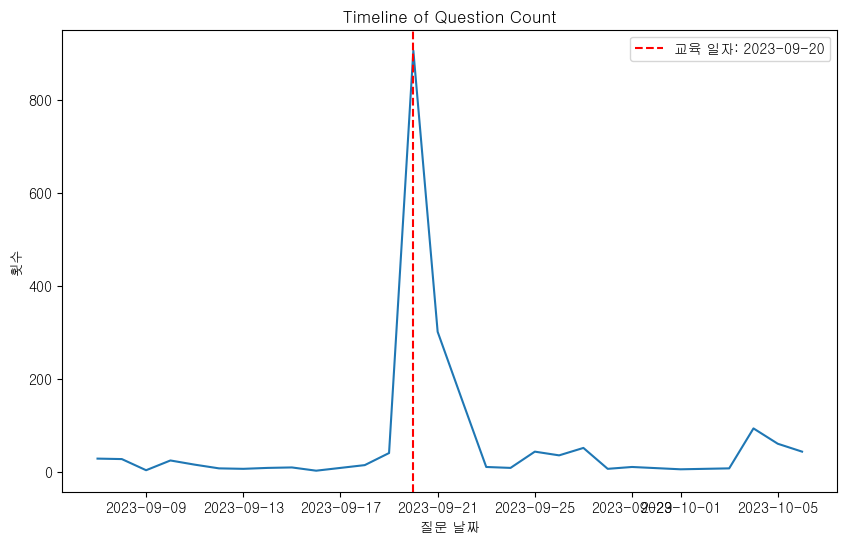

In [124]:
user_count_by_date = df_edu_0920_temp.groupby('CreatedDatetime')[['UserCode']].count()
user_count_by_date.rename(columns={'UserCode':'count'},inplace=True)

## 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=user_count_by_date, x='CreatedDatetime', y='count')

date = '2023-09-20'

date_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
plt.axvline(x=date_obj, color='red', linestyle='--', label=f'교육 일자: {date}')

# 그래프에 레이블 추가
plt.title('Timeline of Question Count')
plt.xlabel('질문 날짜')
plt.ylabel('횟수')
plt.legend()


ValueError: Need to specify at least one of 'labels', 'index' or 'columns'